# Simulation of 2-DoF Ball and Plate Balancing System

## Summary
This assignment is the second step in preparation for the term project. In this lab I develop a simulation and test a controller for the simplified model of the pivoting platform that determined in Lab 0x05. All of the code and documentation for the simulation has been executed in JupyterLab, using Python 3.

## Script Setup
First, import the necessary Python modules

In [1]:
import math
import numpy as np
import sympy as sp
from matplotlib import pyplot
from scipy.integrate import solve_ivp
from sympy import *

from IPython.core.display import display, HTML

then, declare the system variables

In [2]:
x, x_dot, x_ddot, theta_p, theta_dot_p, theta_ddot_p, T_m = sp.symbols("x v a theta omega alpha T_m")

finally, initialize the known parameters/constants of the system

In [3]:
g = 9.806 ## Gravity [m s^(-2)]
b = 10e-3 ## Viscous friction at U-Joint [N m s rad^(-1)]

l_p = 110e-3  ## Length of the platform [m]
l_r = 50e-3   ## Length of the motor rod [m]
r_b = 10.5e-3 ## Radius of the ball [m]
r_g = 42e-3   ## Distance from platform pivot to center of G [m]
r_p = 32.5e-3 ## Distance to center of platform [m]
r_c = 50e-3   ## Distance to surface of platform [m]
r_m = 60e-3   ## Length of the motor arm [m]

m_p = 400e-3 ## Mass of the platform [kg]
m_b = 30e-3  ## Mass of the ball [kg]

I_b = (2/5)*m_b*r_b**2 ## Inertia of the ball [kg m^2]
I_p = 1.88e-3          ## Inertia of the platform [kg m^2]

Previously in Lab 0x05, I manupiulated the analytical model to be represented in the following form:
$$
\left[ \begin{array}{cc} M_{11} & M_{12}
\\ M_{21} & M_{22} \end{array} \right]
\left[ \begin{array}{cc} \ddot{x}
\\ \ddot{\theta}_y \end{array} \right]
= \left[ \begin{array}{cc} f_1(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x
\\ f_2(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x) \end{array} \right]
$$
where the matrix $M$ contains the coefficients of the unknown highest order derivatives, $\ddot{x}$ is the acceleration of the ball parallel to the plate, $\ddot{\theta_p}$ is the angular acceleration of the platform, and $f_1$ and $f_2$ are functions of lower order terms and the motor torque. While this form of model is valid, it is difficult to simulate because it is a non-linear representation of the system and does not express the $\ddot{x}$ and $\ddot{\theta_p}$ explicitly. Before I attempt to simulate the system model, I will have to linearize it and express it in traditional state-space form:
$$
\dot{x}
= A x + B u
$$
where $A$ is the system matrix, $x$ is the state vector, $B$ is the input matrix, and $u$ is the input (control). The first step in transforming the system model from Lab 0x05 is to declare the components in symbolic notation - substituting all of the known system parameters. The matrix $M$ is expressed as,

In [4]:
# The cells of the matrix, M.
M11 = -(m_b*r_b**2 + m_b*r_c*r_b + I_b)/r_b
M12 = - m_b*r_b**2 - 2*m_b*r_b*r_c - m_b*r_c**2 - m_p*r_g**2 - m_b*x**2 - I_b - I_p
M21 = -(m_b*r_b**2 + I_b)/r_b
M22 = - m_b*r_b**2 - m_b*r_c*r_b - I_b

## A matrix containing the coefficients of the unknown highs order derivatives of the system.
M = Matrix(2, 2, [M11, M12, M21, M22])

and the vector $f$ is expressed as,

In [5]:
## The acceleration of the ball expressed as a
#  function of the lower order system terms and motor torque.
f11 = -(g*m_b*r_b*r_m*sin(theta_p) - b*r_m*theta_dot_p - T_m*l_p + g*m_b*r_c*r_m*sin(theta_p) + g*m_p*r_g*r_m*sin(theta_p) - 2*m_b*r_m*theta_dot_p*x*x_dot + g*m_b*r_m*x*cos(theta_p) + m_b*r_b*r_m*theta_dot_p**2*x)/r_m

## The acceleration of the plate expressed as a function
#  of the lower order system terms and motor torque.
f21 = -m_b*r_b*(x*theta_dot_p**2 + g*sin(theta_p))

## A matrix containing accleration of the ball and plate as functions
#  of the lower order system terms and motor torque.
f = Matrix(2, 1, [f11, f21])

Then, the accelerations of the system can be represented explicitly on the LHS of the equation by multiplying both sides of the equation by the inverse of $M$,
$$
\left[ \begin{array}{cc} \ddot{x}
\\ \ddot{\theta}_y \end{array} \right]
= {\left[ \begin{array}{cc} M_{11} & M_{12}
\\ M_{21} & M_{22} \end{array} \right]}^{-1}
\left[ \begin{array}{cc} f_1(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x
\\ f_2(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x) \end{array} \right]
$$
For shorthand, the RHS can be expressed as simply as $\vec{q}$,

In [6]:
## The acceleration of the system components expressed as a set of
#  two second order, non-linear functions (vector).
q = M.inv()*f

This results in the acclerations of the system, $\ddot{x}$ and $\ddot{\theta_p}$, expressed as set of two second-order, nonlinear functions in vector form. These two functions can now be rewritten into state-space form.

## Converting the Model to State-Space Form
The first step in this conversion is to solve for the system matrix, $A$, by computing the jacobian of RHS with respect to the state variables, $x$. The Jacobian matrix is the matrix of all of the first-order partial derivatives of a vector-valued function, which describes the reaction of the system with respect to each variable. Thus, the state matrix is defined as

$$
\mathbf{A}
=
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n}
\\\vdots & \ddots & \vdots
\\\frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}
$$

However, taking the jacobian of a 2x1 vector ($\vec{q}$) with respect to 4 variables ($\dot{x}$, $\dot{\theta_p}$, $x$, $\theta_p$), yeilds a 2x4 matrix. This is a problem since the state matrix, $A$, must be square. To account for this issue, the velocities of the system ($\dot{x}$, $\dot{\theta_p}$) can be added to the LHS of the equation, and the identity matrix can be added to rows 3 and 4 of the state matrix. Thus the Jacobian of the system model with respect to the state variables is defined as,

$$
\mathbf{A}
=
\begin{bmatrix}
\frac{\partial q_1}{\partial \dot{x}} & \frac{\partial q_1}{\partial \dot{\theta_p}} & \frac{\partial q_1}{\partial x} & \frac{\partial q_1}{\partial \theta_p}\\
\frac{\partial q_2}{\partial \dot{x}} & \frac{\partial q_2}{\partial \dot{\theta_p}} & \frac{\partial q_2}{\partial x} & \frac{\partial q_2}{\partial \theta_p}\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
$$

In [7]:
# The state matrix, A, cell components.
A11 = diff(q[0], x_dot)       ## Acceleration of the ball WRT the ball velocity.
A12 = diff(q[0], theta_dot_p) ## Acceleration of the ball WRT the platform velocity.
A13 = diff(q[0], x)           ## Acceleration of the ball WRT the ball position.
A14 = diff(q[0], theta_p)     ## Acceleration of the ball WRT the platform position.
A21 = diff(q[1], x_dot)       ## Acceleration of the platform WRT the ball velocity.
A22 = diff(q[1], theta_dot_p) ## Acceleration of the platform WRT the platform velocity.
A23 = diff(q[1], x)           ## Acceleration of the platform WRT the ball position.
A24 = diff(q[1], theta_p)     ## Acceleration of the platform WRT the platform position.

## The state matrix of the system model, A.
A = Matrix(4, 4, [A11, A12, A13, A14,
                  A21, A22, A23, A24,
                    1,   0,   0,   0,
                    0,   1,   0,   0])

Similarly, the input matrix, $B$, can be calculated by taking the Jacobian of the RHS with respect to the input, $T_m$. Like the previous step, two more rows must be added so that it has a length of 4 so that vector addition can be performed. In this case, zeros are added the velocities of the system are easily defined. We can further justify the use of zeros by considering the dynamics of the system. The torque of the motor does not directly affect the velocities of the system - only the accelerations.

$$
\mathbf{B}
=
\begin{bmatrix}
\frac{\partial q_1}{\partial T_m}\\
\frac{\partial q_2}{\partial T_m}\\
0\\
0
\end{bmatrix}
$$

In [8]:
# The input (control) matrix, B, cell components.
B11 = diff(q[0], T_m) ## Acceleration of the ball WRT the motor torque.
B21 = diff(q[1], T_m) ## Acceleration of the platform WRT the motor torque.

## The input (control) matrix of the system model, B.
B = Matrix(4, 1, [B11,
                  B21,
                    0,
                    0])

## Linearization of the Model
Now the system model is expressed in state-space form; but, it must be linearized. The state matrix, $A$, and the input matrix, $B$, still contain non-constant values. One of the assumptions made previously in Lab 0x05 is that the system will operate close to its equillibrium point. That is, the plate will operate close to parallel and the ball will be close to the center of the platform. With this assumption, we can define the states of the system to be zero
$$
\dot{x}, \dot{\theta_p}, x, \theta_p, T_m = 0
$$
at equllibrium. While this approximation makes the model simulation much simpler, it does further reduce its accuracy. As the position of the ball/angle of the platform travel farther from the equillibrium position, the simulation will be more innaccurate - much like a Taylor series.

In [9]:
A = A.subs({x_dot: 0, theta_dot_p: 0, x: 0, theta_p: 0, T_m: 0})
print(A)

Matrix([[0, 0.177268044626614, -5.21487133682572, 4.00945960370866], [0, -3.83578458233786, 112.841110843215, 64.8030379413892], [1, 0, 0, 0], [0, 1, 0, 0]])


In [10]:
B = B.subs(x, 0)
print(B)

Matrix([[32.4991415148792], [-703.227173428607], [0], [0]])


Now that the system model has linearized and rearranged into state-space form, we can use numerical integration to simulate the response to various inputs.

## Simulation Functions: System ODE and Plotter
Before running the simulation, it is critical to define the function of the system model. This way the (numerical) ODE solver imported from the SciPy can recognize the interpret the system behavior. With the system model linearized and expressed in state-space form, the function becomes quite simple. Instead of defining multiple functions for cases with different feedback and input signals, a single ODE function that accepts arguements that define the behavior of the input vector, $u$, can be used for every case.

In [11]:
def system_ODE(time, states, feedback='closed', signal='none', T_m=1e-3):
    '''
    @brief       A set of linear, first order ODEs.
    @details     The state-space representation of the
                 2-Dof ball balancing system which defines
                 the acceleration/velocity of the platform/ball.
    @param       time The simulation time [start, end].
    @param       states The system state vector [x_dot, theta_p_dot, x, theta_p].
    @param       feedback The feedback control behavior of the system: 'open' or 'closed'.
    @param       signal The behavior of the input signal of the system: 'none' or 'impulse'.
    @param   T_m The magnitude of the torque applied to the system by the motor - 
                 applied as an impulse signal.
    @return  q A vector containing the derivatives of the system states -
               [x_ddot, theta_p_ddot, x, theta_p]
    '''
    
    states = Matrix(4,1, [states[0], states[1], states[2], states[3]])
    
    # Case for closed-loop and no input
    if feedback == 'open' and signal == 'none':
        u = 0 # No input
    
    # Case for closed-loop and an impulse motor torque (0.05 seconds)
    elif feedback == 'open' and signal == 'impulse':
        u = T_m/0.05 if (time > 0 and time < 0.05) else 0 # Approximate Dirac function w/magnitude T_m (scaled)
    
    # Case for open-loop and no input
    elif feedback == 'closed' and signal == 'none':
        K      = Matrix(1, 4, [-0.05, -0.02, -0.30, -0.20])
        states = Matrix(4,1, [states[0], states[1], states[2], states[3]]) 
        u      = -(K*states)
    
    # Case for closed-loop and an impulse motor torque (0.05 seconds)
    elif feedback == 'closed' and signal == 'impulse':
        K      = Matrix(1, 4, [-0.05, -0.02, -0.30, -0.20])
        states = Matrix(4,1, [states[0], states[1], states[2], states[3]]) 
        u = T_m/(0.05) if (time > 0 and time < 0.05) else (-K*states)
        
    # Error handling
    else:
        return
    
    ## The derivatives of the system states.
    q = A*states+B*u
    
    return [q[0], q[1], q[2], q[3]]

Next, a function used to plot the dynamic responses of all four of the state variables ($\dot{x}, \dot{\theta_p}, x, \theta_p, T_m$), can be defined.

In [12]:
def plot_response(results):
    '''
    @brief         Plots the response of the ball balancing model simulation.
    @details       Generates plots for the dynamic responses of each
                   state variable of the ball balancing model simulation,
                   each as a function of time. The subplots of the system model
                   velocities are located in the first row, and the
                   suplots of the system model positions are located in the second row.
                   The subplots of the ball response of the ball are located in the
                   first column, and the suplots of the platform response
                   are located in the second column
    @param results A bunch object containing the simulation results of an ODE solver.
    '''   
    # Create the figure with 4 suplots
    fig, ax = pyplot.subplots(2, 2, figsize=(20,8)) # , sharex='col'
    
    # Velocity response of the ball
    ax[0, 0].plot(results.t, results.y[0], color='maroon', linestyle='-')
    ax[0, 0].set_ylabel('Velocity, $\mathit{\dot{x}}$ [m/s]')
    ax[0, 0].set_title('Velocity Response of the Ball (Relative to the Platform)')
    
    # Position response of the ball
    ax[1, 0].plot(results.t, results.y[2], color='green', linestyle='-')
    ax[1, 0].set_ylabel('Position, $\mathit{x}$ [m]')
    ax[1, 0].set_xlabel('Time, $\mathit{t}$ [seconds]')                
    ax[1, 0].set_title('Position Response of the Ball (Relative to the Platform)')                 
    
    # Velocity response of the platform
    ax[0, 1].plot(results.t, results.y[1], color='mediumblue', linestyle='-')
    ax[0, 1].set_ylabel('Angular Velocity, $\mathit{\dot{θ_p}}$ [rad/s]')
    ax[0, 1].set_title('Velocity Response of the Platform')
    
    # Position response of the platform
    ax[1, 1].plot(results.t, results.y[3], color='darkorange', linestyle='-')
    ax[1, 1].set_ylabel('Angular Position, $\mathit{θ_p}$ [rad]')
    ax[1, 1].set_xlabel('Time, $\mathit{t}$ [seconds]')                
    ax[1, 1].set_title('Position Response of the Platform')
    
    # Apply gridlines/tick marks to each subplot
    for row in range(len(ax)):
        for col in range(len(ax)):
            ax[row,col].grid(True, linestyle='-.', alpha=0.5)
            ax[row,col].tick_params(left=True, bottom=True, top=True, right=True, direction='in')

    # Show the plots       
    pyplot.show()

Now it is easy to plot each of the case scenarios.
# Results
In this section, I will run the simulation for a series of four cases. For each case, I will generate a series of plots showing the dynamic response for *each* state variable ($\dot{x}, \dot{\theta_p}, x, \theta_p$), each plotted as a function of time. First, I will define a function that represents the system model. Each of the results can be easily accessed below:

## Open-Loop Responses
For testing the simulation in open-loop, there will be no form of feedback to help stablize the system. As one could imagine, a ball balancing on a platform is an extremely unstable system - it's similar to an inverted pendulum. One could imagine that the ball is likely to fall off the platform if it is place anywhere other than the *very* center of the platform, which is very difficult to do in the first place. Moreover, as we saw in Lab 0x05, the some of the eigen-values of the system have nonreal components and there is a pole located in the far positive axis. These two components further indicate that the system is unstable. Therefore, we should expect to see the response of the system diverge if the initial conditions of the state variables are not at equillibrium.

### Case 1 (open)
The ball is initially at rest on a level platform directly above the center of gravity of the platform and there is no torque input from the motor. Run this simulation for $1 [s]$.

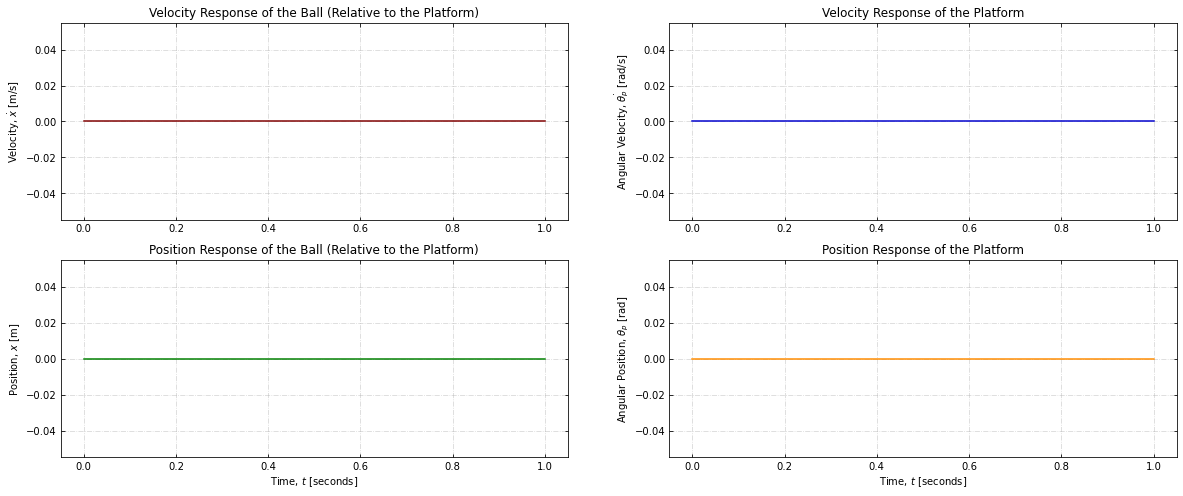

In [13]:
## The initial conditions (SI) of the state variables of the system model -
#  [x_dot, theta_dot_p, x, theta_p].
initial_conditions = [0, 0, 0, 0]

## The simulation time, in seconds, for the system model -
#  [start_time, end_time]. 
sim_time = [0.0, 1.0]

## The bunch object containing the results of the simulation response.
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='open', signal='none'), sim_time, initial_conditions, rtol=1e-6)

# Plot the response of the system
plot_response(sim_results)

### Case 2 (open)
The ball is initially at rest on a level platform offset horizontally from the center of gravity of the platform by $5 [cm]$ and there is no torque input from the motor. Run this simulation for $0.4 [s]$.

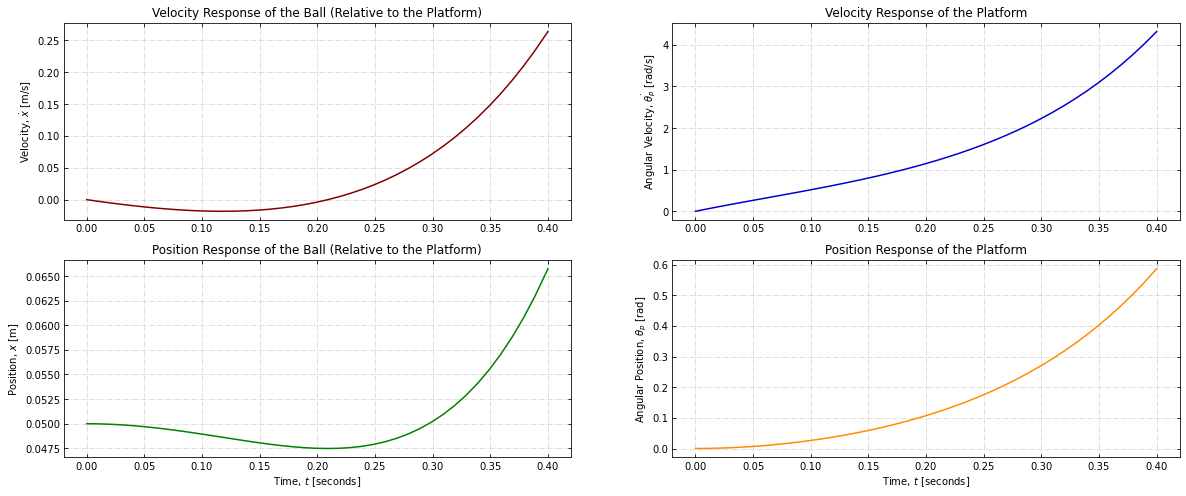

In [14]:
initial_conditions = [0, 0, 5e-2, 0]
sim_time = [0.0, 0.4]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='open', signal='none'), sim_time, initial_conditions, max_step=1e-2, rtol=1e-9)
plot_response(sim_results)

### Case 3 (open)
The ball is initially at rest on a platform inclined at $5^{\circ}$ directly above the center of gravity of the platform and there is no torque input from the motor.  Run this simulation for $0.4 [s]$.

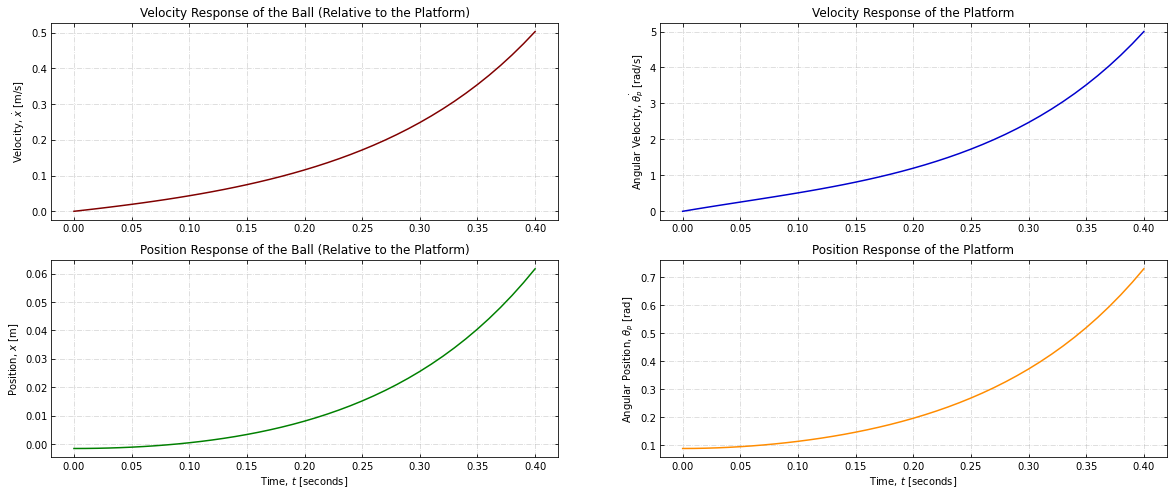

In [15]:
## Distance of the ball, x, from the centerpoint so that the CG of the ball is directly above the CG of the platform inclined at 5 degrees.
x_dist = -(r_c+r_b-r_g)*np.tan(np.deg2rad(5))
           
initial_conditions = [0, 0, x_dist, (np.deg2rad(5))]
sim_time = [0.0, 0.4]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='open', signal='none'), sim_time, initial_conditions, max_step=1e-2, rtol=1e-9)
plot_response(sim_results)

### Case 4 (open)
The ball is initially at rest on a level platform directly above the center of gravity of the platform and there is an impulse of 1 mNm·s applied by the motor. Run this simulation for 0.4 [s].

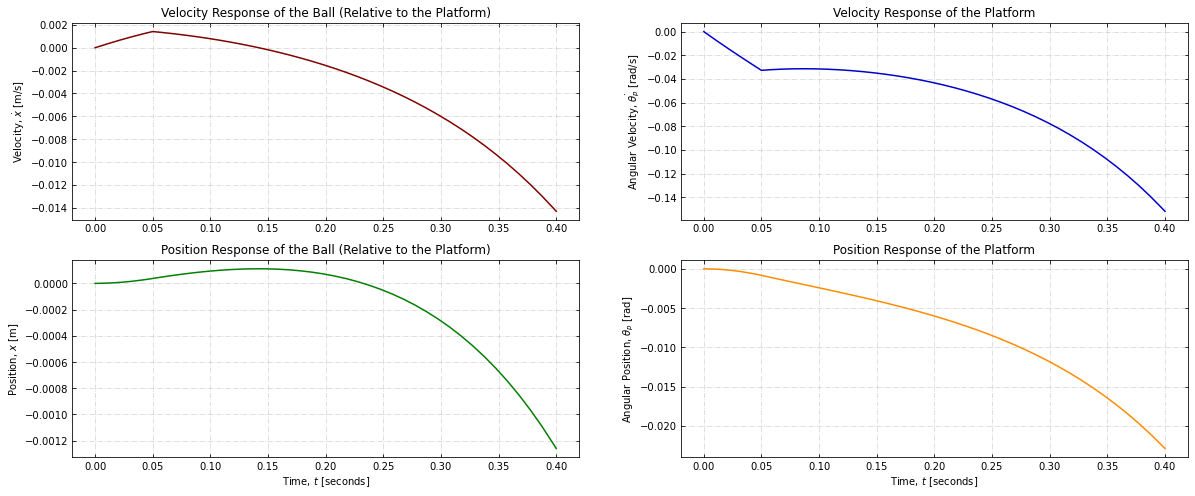

In [16]:
initial_conditions = [0, 0, 0, 0]
sim_time = [0.0, 0.4]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='open', signal='impulse', T_m=1e-3), sim_time, initial_conditions, max_step=1e-2, rtol=1e-9)
plot_response(sim_results)

## Closed-Loop Responses
Now, I will test the simulation in closed-loop by implementing a regulator using full state feedback by substituting a gain controller fir the input (control) vector. In matrix notation, this equation can be expressed as:

$$
\mathbf{T_m} = -\begin{bmatrix} K_1 & K_2 & K_3 & K_4 \end{bmatrix}  \begin{bmatrix} \dot{x} \\ \dot{\theta_p} \\ x \\ \theta_p \end{bmatrix}
$$

where the gains to test the system performance in closed-loop have been predetermined to be

$$
\mathbf{K} = -\begin{bmatrix} -0.05 & -0.02 & -0.3 & -0.2 \end{bmatrix}
$$

The individual gains in the K matrix shown above are in SI units matching the states and input. That is, going left-to-right, the units for $K_1$ through $K_4$ are $[N·s]$, $[N·m·s]$, $[N]$, and $[N·m]$ respectively. These gains implement a nearly fuel-optimal controller; that is, these gains stabilize the system while minimizing the amount of actuation effort required for stability. These gains will therefore not offer high performance.

### Case 1 (closed)
The ball is initially at rest on a level platform directly above the center of gravity of the platform and there is no torque input from the motor. Run this simulation for $1 [s]$.

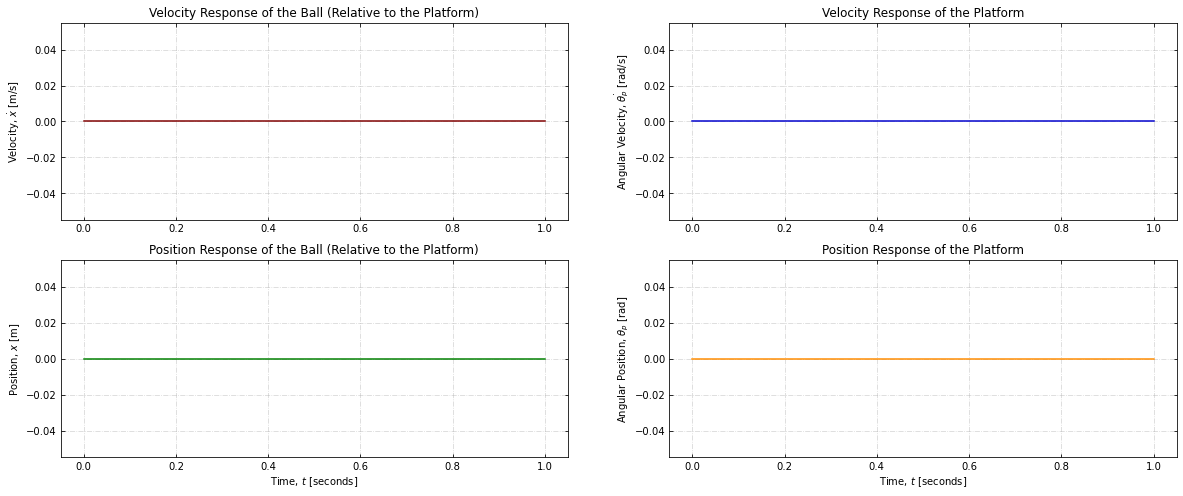

In [17]:
initial_conditions = [0, 0, 0, 0]
sim_time = [0.0, 1.0]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='closed'), sim_time, initial_conditions, rtol=1e-6)
plot_response(sim_results)

### Case 2 (closed)
The ball is initially at rest on a level platform offset horizontally from the center of gravity of the platform by $5 [cm]$ and there is no torque input from the motor. Run this simulation for $0.4 [s]$.

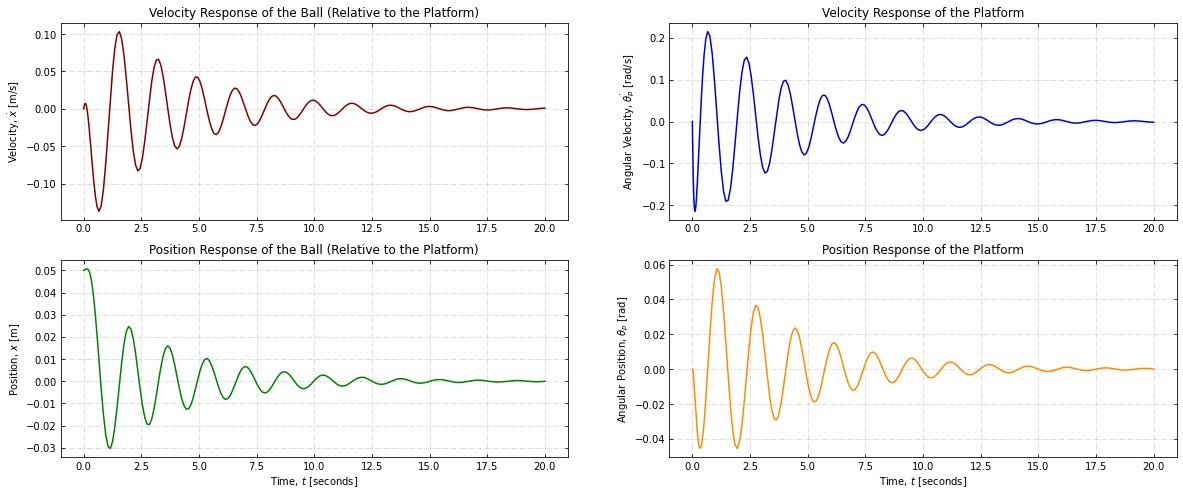

In [18]:
initial_conditions = [0, 0, 5e-2, 0]
sim_time = [0.0, 20]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='closed'), sim_time, initial_conditions, max_step=0.1, rtol=1e-9)
plot_response(sim_results)

### Case 3 (closed)
The ball is initially at rest on a platform inclined at $5^{\circ}$ directly above the center of gravity of the platform and there is no torque input from the motor.  Run this simulation for $0.4 [s]$.

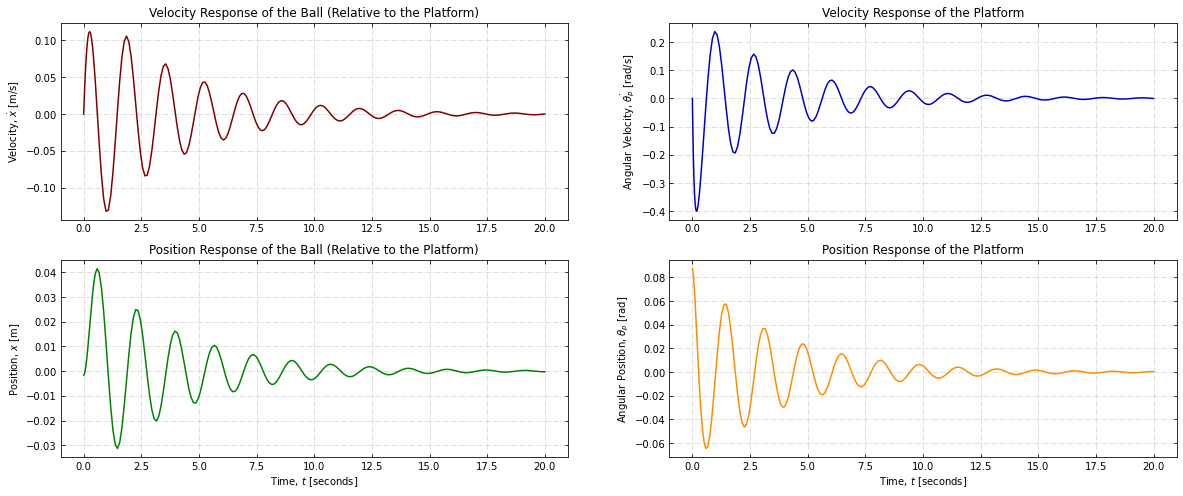

In [19]:
## Distance of the ball, x, from the centerpoint so that the CG of the ball is directly above the CG of the platform inclined at 5 degrees.
x_dist = -(r_c+r_b-r_g)*np.tan(np.deg2rad(5))
initial_conditions = [0, 0, x_dist, (np.deg2rad(5))]
sim_time = [0.0, 20]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='closed'), sim_time, initial_conditions, max_step=0.1, rtol=1e-9)
plot_response(sim_results)

### Case 4 (closed)
The ball is initially at rest on a level platform directly above the center of gravity of the platform and there is an impulse of 1 mNm·s applied by the motor. Run this simulation for 0.4 [s].

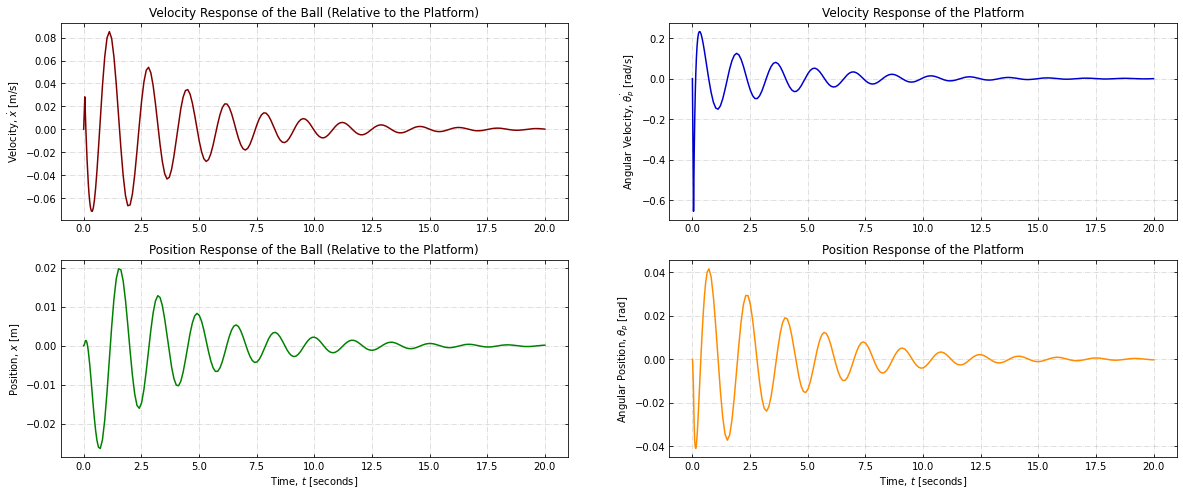

In [20]:
initial_conditions = [0, 0, 0, 0]
sim_time = [0.0, 20]
sim_results = solve_ivp(lambda t,y: system_ODE(t, y, feedback='closed', signal='impulse', T_m=1e-3), sim_time, initial_conditions, max_step=0.1, rtol=1e-9)
plot_response(sim_results)